<a href="https://colab.research.google.com/github/thaiqtran/EE-399-HW-6/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/thaiqtran/EE-399-HW-6/blob/main/README.md

In [ ]:
!git clone https://github.com/shervinsahba/pyshred


Cloning into 'pyshred'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 42 (delta 20), reused 26 (delta 9), pack-reused 0
Unpacking objects: 100% (42/42), 223.89 KiB | 2.73 MiB/s, done.


In [ ]:
%cd pyshred

/content/pyshred


In [ ]:
import numpy as np
from processdata import load_data
from processdata import TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

epoch: 1000 valid_error: tensor(0.1175, device='cuda:0'): 100%|██████████| 1000/1000 [02:37<00:00,  6.34it/s]


0.020014059


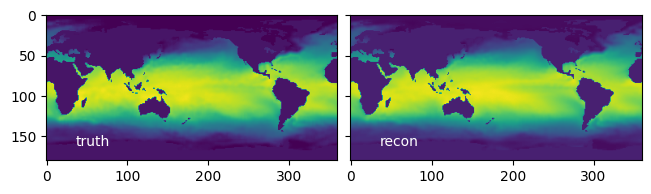

In [ ]:
from processdata import load_full_SST

# SST data with world map indices for plotting
full_SST, sst_locs = load_full_SST()
full_test_truth = full_SST[test_indices, :]

# replacing SST data with our reconstruction
full_test_recon = full_test_truth.copy()
full_test_recon[:,sst_locs] = test_recons

# reshaping to 2d frames
for x in [full_test_truth, full_test_recon]:
    x.resize(len(x),180,360)

plotdata = [full_test_truth, full_test_recon]
labels = ['truth','recon']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

epoch: 640 valid_error: tensor(0.1377, device='cuda:0'):  64%|██████▍   | 639/1000 [01:35<00:54,  6.66it/s]
epoch: 1000 valid_error: tensor(0.1083, device='cuda:0'): 100%|██████████| 1000/1000 [02:30<00:00,  6.65it/s]
epoch: 760 valid_error: tensor(0.1088, device='cuda:0'):  76%|███████▌  | 759/1000 [01:55<00:36,  6.57it/s]
epoch: 940 valid_error: tensor(0.1073, device='cuda:0'):  94%|█████████▍| 939/1000 [02:23<00:09,  6.52it/s]
epoch: 840 valid_error: tensor(0.1051, device='cuda:0'):  84%|████████▍ | 839/1000 [02:09<00:24,  6.46it/s]


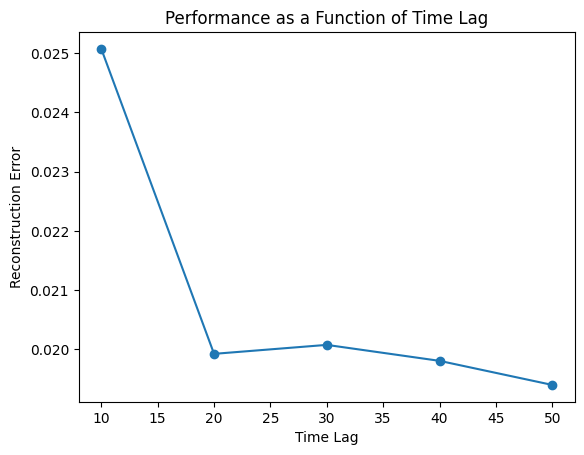

In [ ]:
# Define the time lag values to evaluate
time_lag_values = [10, 20, 30, 40, 50]

# Load the data and perform scaling
load_X = load_data('SST')
sc = MinMaxScaler()
sc = sc.fit(load_X)
transformed_X = sc.transform(load_X)

# Define the number of sensors and other parameters
num_sensors = 3
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

# Define empty list to store performance metrics for each time lag
performance_metrics = []

# Iterate over the time lag values
for lags in time_lag_values:
    # Generate input sequences to the SHRED model
    all_data_in = np.zeros((n - lags, lags, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i + lags, sensor_locations]

    # Generate training, validation, and test datasets for state reconstruction and sensor forecasting
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Create and train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

    # Calculate reconstruction error
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    reconstruction_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)

    # Store the performance metric for the current time lag value
    performance_metrics.append(reconstruction_error)

# Plot the performance as a function of the time lag variable
plt.plot(time_lag_values, performance_metrics, marker='o')
plt.xlabel('Time Lag')
plt.ylabel('Reconstruction Error')
plt.title('Performance as a Function of Time Lag')
plt.show()


epoch: 560 valid_error: tensor(0.2613, device='cuda:0'):  56%|█████▌    | 559/1000 [01:22<01:05,  6.77it/s]
epoch: 460 valid_error: tensor(0.2611, device='cuda:0'):  46%|████▌     | 459/1000 [01:08<01:20,  6.73it/s]
epoch: 480 valid_error: tensor(0.2654, device='cuda:0'):  48%|████▊     | 479/1000 [01:10<01:17,  6.75it/s]
epoch: 300 valid_error: tensor(0.2708, device='cuda:0'):  30%|██▉       | 299/1000 [00:44<01:44,  6.73it/s]
epoch: 300 valid_error: tensor(0.2697, device='cuda:0'):  30%|██▉       | 299/1000 [00:44<01:43,  6.75it/s]


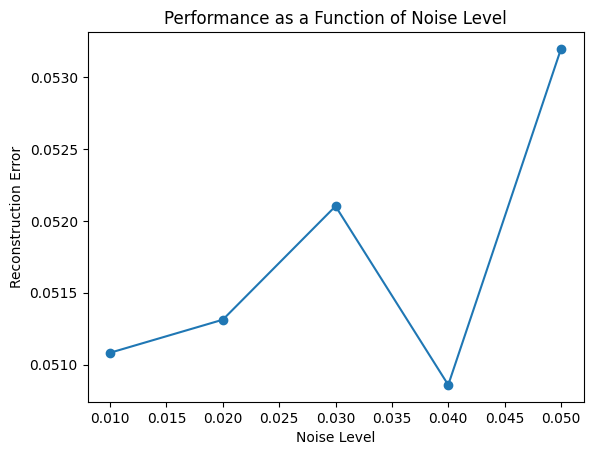

In [ ]:
# Define the noise levels to evaluate
noise_levels = [0.01, 0.02, 0.03, 0.04, 0.05]

# Load the data and perform scaling
load_X = load_data('SST')
sc = MinMaxScaler()
sc = sc.fit(load_X)
transformed_X = sc.transform(load_X)

# Define the number of sensors and other parameters
num_sensors = 3
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

# Define empty list to store performance metrics for each noise level
performance_metrics = []

# Iterate over the noise levels
for noise_level in noise_levels:
    # Generate noisy data by adding Gaussian noise to the scaled data
    noisy_X = transformed_X + np.random.normal(loc=0, scale=noise_level, size=transformed_X.shape)

    # Generate input sequences to the SHRED model
    all_data_in = np.zeros((n, 1, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = noisy_X[i, sensor_locations].reshape(1, -1)

    # Generate training, validation, and test datasets for state reconstruction and sensor forecasting
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(transformed_X[train_indices], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Create and train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

    # Calculate reconstruction error
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    reconstruction_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)

    # Store the performance metric for the current noise level
    performance_metrics.append(reconstruction_error)

# Plot the performance as a function of the noise level
plt.plot(noise_levels, performance_metrics, marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Reconstruction Error')
plt.title('Performance as a Function of Noise Level')
plt.show()


epoch: 1000 valid_error: tensor(0.1099, device='cuda:0'): 100%|██████████| 1000/1000 [02:34<00:00,  6.47it/s]
epoch: 1000 valid_error: tensor(0.1107, device='cuda:0'): 100%|██████████| 1000/1000 [02:35<00:00,  6.44it/s]
epoch: 740 valid_error: tensor(0.1117, device='cuda:0'):  74%|███████▍  | 739/1000 [01:54<00:40,  6.43it/s]
epoch: 900 valid_error: tensor(0.1095, device='cuda:0'):  90%|████████▉ | 899/1000 [02:19<00:15,  6.46it/s]
epoch: 940 valid_error: tensor(0.1090, device='cuda:0'):  94%|█████████▍| 939/1000 [02:25<00:09,  6.46it/s]


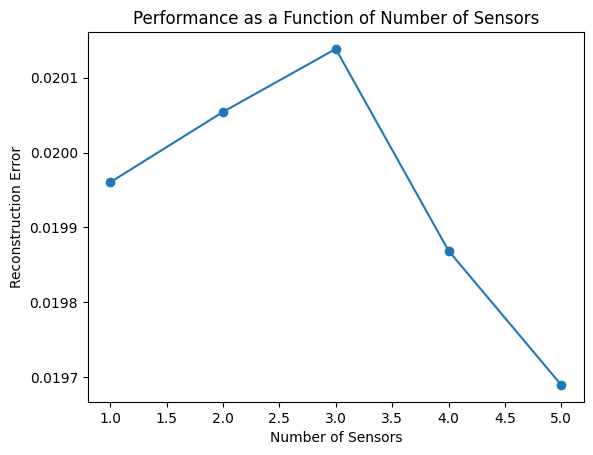

In [ ]:
# Define the number of sensors to evaluate
sensor_counts = [1, 2, 3, 4, 5]

# Load the data and perform scaling
load_X = load_data('SST')
sc = MinMaxScaler()
sc = sc.fit(load_X)
transformed_X = sc.transform(load_X)

# Define the time lag and other parameters
time_lag = 52
n = load_X.shape[0]
m = load_X.shape[1]

# Define empty list to store performance metrics for each number of sensors
performance_metrics = []

# Iterate over the number of sensors
for num_sensors in sensor_counts:
    # Select random sensor locations
    sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

    # Generate input sequences to the SHRED model
    all_data_in = np.zeros((n - time_lag, time_lag, num_sensors))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+time_lag, sensor_locations]

    # Generate training, validation, and test datasets for state reconstruction and sensor forecasting
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    train_data_out = torch.tensor(transformed_X[train_indices + time_lag - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + time_lag - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + time_lag - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    # Create and train the SHRED model
    shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
    validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

    # Calculate reconstruction error
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    reconstruction_error = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)

    # Store the performance metric for the current number of sensors
    performance_metrics.append(reconstruction_error)

# Plot the performance as a function of the number of sensors
plt.plot(sensor_counts, performance_metrics, marker='o')
plt.xlabel('Number of Sensors')
plt.ylabel('Reconstruction Error')
plt.title('Performance as a Function of Number of Sensors')
plt.show()
